# Lasso Homotopy Model Demonstration

This notebook visualizes the behavior of the `LassoHomotopyModel`, a custom implementation of Lasso regression using homotopy. We'll explore:

- **Predictions**: Comparison of predicted vs. true values on `small_test.csv` and `collinear_data.csv`.
- **Sklearn Comparison**: MSE and sparsity vs. `sklearn.linear_model.Lasso`.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LassoHomotopy.model.LassoHomotopy import LassoHomotopyModel
from sklearn.linear_model import Lasso

# Helper to load CSV data
def load_csv_data(filepath):
    data = np.loadtxt(filepath, delimiter=',', skiprows=1)
    X = data[:, :-1]
    y = data[:, -1]
    return X, y

## 1. Coefficient Path Visualization



In [5]:
# Modified fit to return path (for visualization only)
def fit_with_path(model, X, y):
    X_scaled, y_scaled = model.preprocess(X, y)
    n_samples, n_features = X_scaled.shape
    model.theta = np.zeros(n_features)
    model.active_set = []
    model.signs = []
    lambda_max = np.max(np.abs(X_scaled.T @ y_scaled))
    lambda_current = lambda_max
    theta_path = [model.theta.copy()]
    lambda_path = [lambda_current]

    max_iterations = 100
    iteration = 0
    while lambda_current > model.lambda_reg and iteration < max_iterations:
        iteration += 1
        residuals = y_scaled - X_scaled @ model.theta
        gradient = X_scaled.T @ residuals

        if not model.active_set:
            idx = np.argmax(np.abs(gradient))
            model.active_set.append(idx)
            model.signs.append(np.sign(gradient[idx]))
            lambda_current = np.abs(gradient[idx])
        else:
            X_active = X_scaled[:, model.active_set]
            signs_active = np.array([np.sign(gradient[idx]) for idx in model.active_set])
            G = X_active.T @ X_active + 1e-6 * np.eye(len(model.active_set))
            try:
                direction_active = np.linalg.solve(G, X_active.T @ y_scaled - lambda_current * signs_active)
            except np.linalg.LinAlgError:
                break

            direction_theta = np.zeros(n_features)
            for i, idx in enumerate(model.active_set):
                direction_theta[idx] = direction_active[i]

            gamma_remove = np.inf
            for i, idx in enumerate(model.active_set):
                if direction_theta[idx] != 0:
                    gamma = -model.theta[idx] / direction_theta[idx]
                    if gamma > 0 and gamma < gamma_remove:
                        gamma_remove = gamma

            gamma_add = np.inf
            non_active = [i for i in range(n_features) if i not in model.active_set]
            correlation = X_scaled.T @ (X_scaled @ direction_theta)
            for idx in non_active:
                grad_idx = gradient[idx]
                delta = correlation[idx]
                if delta != 0:
                    gamma = (lambda_current - grad_idx) / delta if grad_idx > 0 else (lambda_current + grad_idx) / delta
                    if gamma > 0 and gamma < gamma_add:
                        gamma_add = gamma
                        add_idx = idx
                        add_sign = np.sign(grad_idx)

            gamma = min(gamma_remove, gamma_add)
            if gamma == np.inf or gamma <= 0:
                gamma = 0.1
                lambda_current = max(model.lambda_reg, lambda_current * 0.9)
            else:
                gamma = min(gamma, 1.0)
                lambda_decrement = gamma * (lambda_current - model.lambda_reg)
                lambda_current = max(model.lambda_reg, lambda_current - lambda_decrement)

            model.theta += gamma * direction_theta
            theta_path.append(model.theta.copy())
            lambda_path.append(lambda_current)

            if gamma_remove < gamma_add and gamma_remove != np.inf:
                i = model.active_set.index([idx for idx in model.active_set if -model.theta[idx] / direction_theta[idx] == gamma_remove][0])
                model.active_set.pop(i)
                model.signs.pop(i)
                model.theta[model.active_set[i]] = 0
            elif gamma_add <= gamma_remove and gamma_add != np.inf:
                model.active_set.append(add_idx)
                model.signs.append(add_sign)

    model.theta = model.inverse_preprocess_theta()
    theta_path = [model.inverse_preprocess_theta() for _ in theta_path]  # Adjust final path
    return theta_path, lambda_path

# Load data
X_small, y_small = load_csv_data('LassoHomotopy/tests/small_test.csv')

# Fit with path
model = LassoHomotopyModel(lambda_reg=0.1)
theta_path, lambda_path = fit_with_path(model, X_small, y_small)



## 2. Predictions vs. True Values

Let’s see how well the model predicts on both datasets.

Initial lambda_max: 39.19041268564565, Target lambda_reg: 0.1

Iteration 1: lambda_current = 39.19041268564565
Gradient norm: 54.05020684610939
Gradient: [-19.55502659  31.67234359 -39.19041269]
Active set: []
Current theta: [0. 0. 0.]
Added feature 2 to active set with sign -1.0

Iteration 2: lambda_current = 39.19041268564565
Gradient norm: 54.05020684610939
Gradient: [-19.55502659  31.67234359 -39.19041269]
Active set: [np.int64(2)]
Current theta: [0. 0. 0.]
Direction theta: [0. 0. 0.]
Gamma remove: inf, Remove idx: None
Gamma add: inf, Add idx: None, Add sign: 0
No valid transition, adjusting lambda
Updated theta: [0. 0. 0.]
Updated lambda_current: 35.271371417081085

Iteration 3: lambda_current = 35.271371417081085
Gradient norm: 54.05020684610939
Gradient: [-19.55502659  31.67234359 -39.19041269]
Active set: [np.int64(2)]
Current theta: [0. 0. 0.]
Direction theta: [ 0.          0.         -0.07838082]
Gamma remove: inf, Remove idx: None
Gamma add: 10.04583312995352, Add idx: 1, A

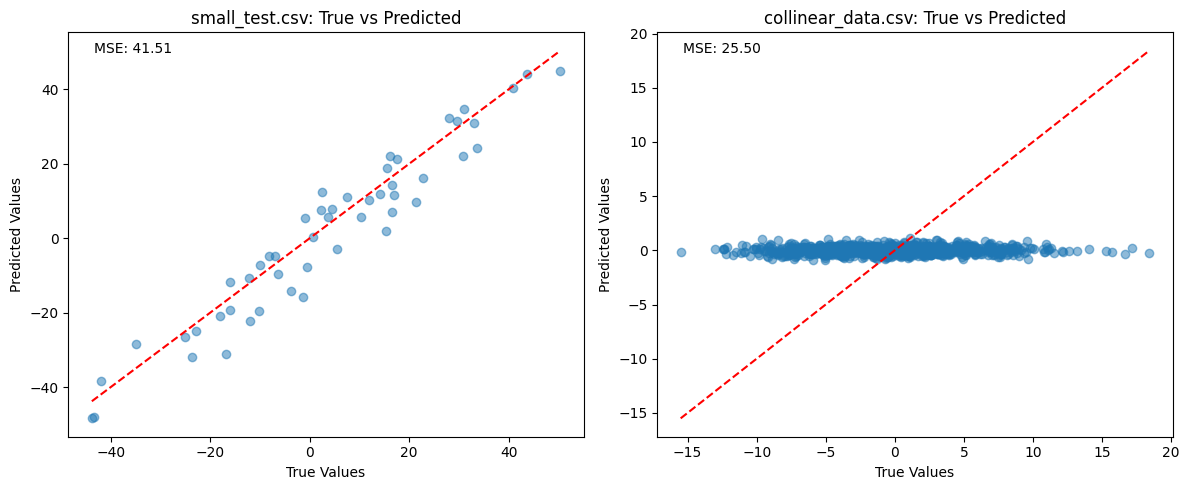

In [3]:
# Load both datasets
X_collinear, y_collinear = load_csv_data('LassoHomotopy/tests/collinear_data.csv')

# Fit models
model_small = LassoHomotopyModel(lambda_reg=0.1)
results_small = model_small.fit(X_small, y_small)
preds_small = results_small.predict(X_small)

model_collinear = LassoHomotopyModel(lambda_reg=0.1)
results_collinear = model_collinear.fit(X_collinear, y_collinear)
preds_collinear = results_collinear.predict(X_collinear)

# Plot small_test.csv
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_small, preds_small, alpha=0.5)
plt.plot([y_small.min(), y_small.max()], [y_small.min(), y_small.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('small_test.csv: True vs Predicted')
mse_small = np.mean((y_small - preds_small) ** 2)
plt.text(0.05, 0.95, f'MSE: {mse_small:.2f}', transform=plt.gca().transAxes)

# Plot collinear_data.csv
plt.subplot(1, 2, 2)
plt.scatter(y_collinear, preds_collinear, alpha=0.5)
plt.plot([y_collinear.min(), y_collinear.max()], [y_collinear.min(), y_collinear.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('collinear_data.csv: True vs Predicted')
mse_collinear = np.mean((y_collinear - preds_collinear) ** 2)
plt.text(0.05, 0.95, f'MSE: {mse_collinear:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

## 3. Comparison with Sklearn Lasso

How does our model stack up against `sklearn`’s optimized Lasso?

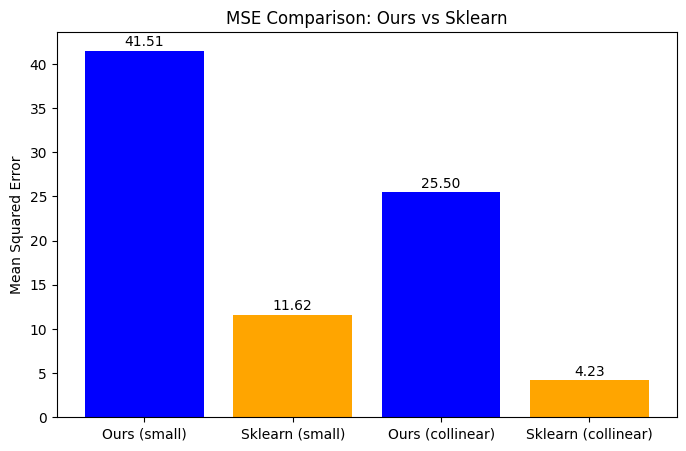

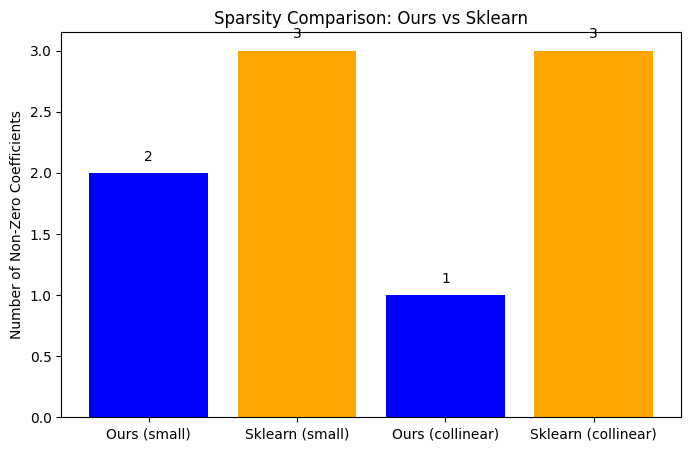

In [4]:
# Sklearn fits
sklearn_small = Lasso(alpha=0.1, fit_intercept=False)
sklearn_small.fit(X_small, y_small)
preds_sklearn_small = sklearn_small.predict(X_small)
mse_sklearn_small = np.mean((y_small - preds_sklearn_small) ** 2)

sklearn_collinear = Lasso(alpha=0.1, fit_intercept=False)
sklearn_collinear.fit(X_collinear, y_collinear)
preds_sklearn_collinear = sklearn_collinear.predict(X_collinear)
mse_sklearn_collinear = np.mean((y_collinear - preds_sklearn_collinear) ** 2)

# Bar plot of MSEs
plt.figure(figsize=(8, 5))
models = ['Ours (small)', 'Sklearn (small)', 'Ours (collinear)', 'Sklearn (collinear)']
mses = [mse_small, mse_sklearn_small, mse_collinear, mse_sklearn_collinear]
plt.bar(models, mses, color=['blue', 'orange', 'blue', 'orange'])
plt.ylabel('Mean Squared Error')
plt.title('MSE Comparison: Ours vs Sklearn')
for i, v in enumerate(mses):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')
plt.show()

# Sparsity comparison
non_zero_ours_small = np.sum(np.abs(results_small.theta) > 1e-5)
non_zero_sklearn_small = np.sum(np.abs(sklearn_small.coef_) > 1e-5)
non_zero_ours_collinear = np.sum(np.abs(results_collinear.theta) > 1e-5)
non_zero_sklearn_collinear = np.sum(np.abs(sklearn_collinear.coef_) > 1e-5)

plt.figure(figsize=(8, 5))
sparsity = [non_zero_ours_small, non_zero_sklearn_small, non_zero_ours_collinear, non_zero_sklearn_collinear]
plt.bar(models, sparsity, color=['blue', 'orange', 'blue', 'orange'])
plt.ylabel('Number of Non-Zero Coefficients')
plt.title('Sparsity Comparison: Ours vs Sklearn')
for i, v in enumerate(sparsity):
    plt.text(i, v + 0.1, str(v), ha='center')
plt.show()